In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

metadata=pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
print(metadata.head())


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [2]:
path1="/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
path2="/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"

def get_image_path(image_id):
    img_id=image_id +".jpg"
    if os.path.exists(os.path.join(path1, image_id + ".jpg")):
        return os.path.join(path1, img_id)
    else:
        return os.path.join(path2, img_id)

metadata['image_path'] = metadata['image_id'].apply(get_image_path)


In [3]:
print(metadata['dx'].value_counts())


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


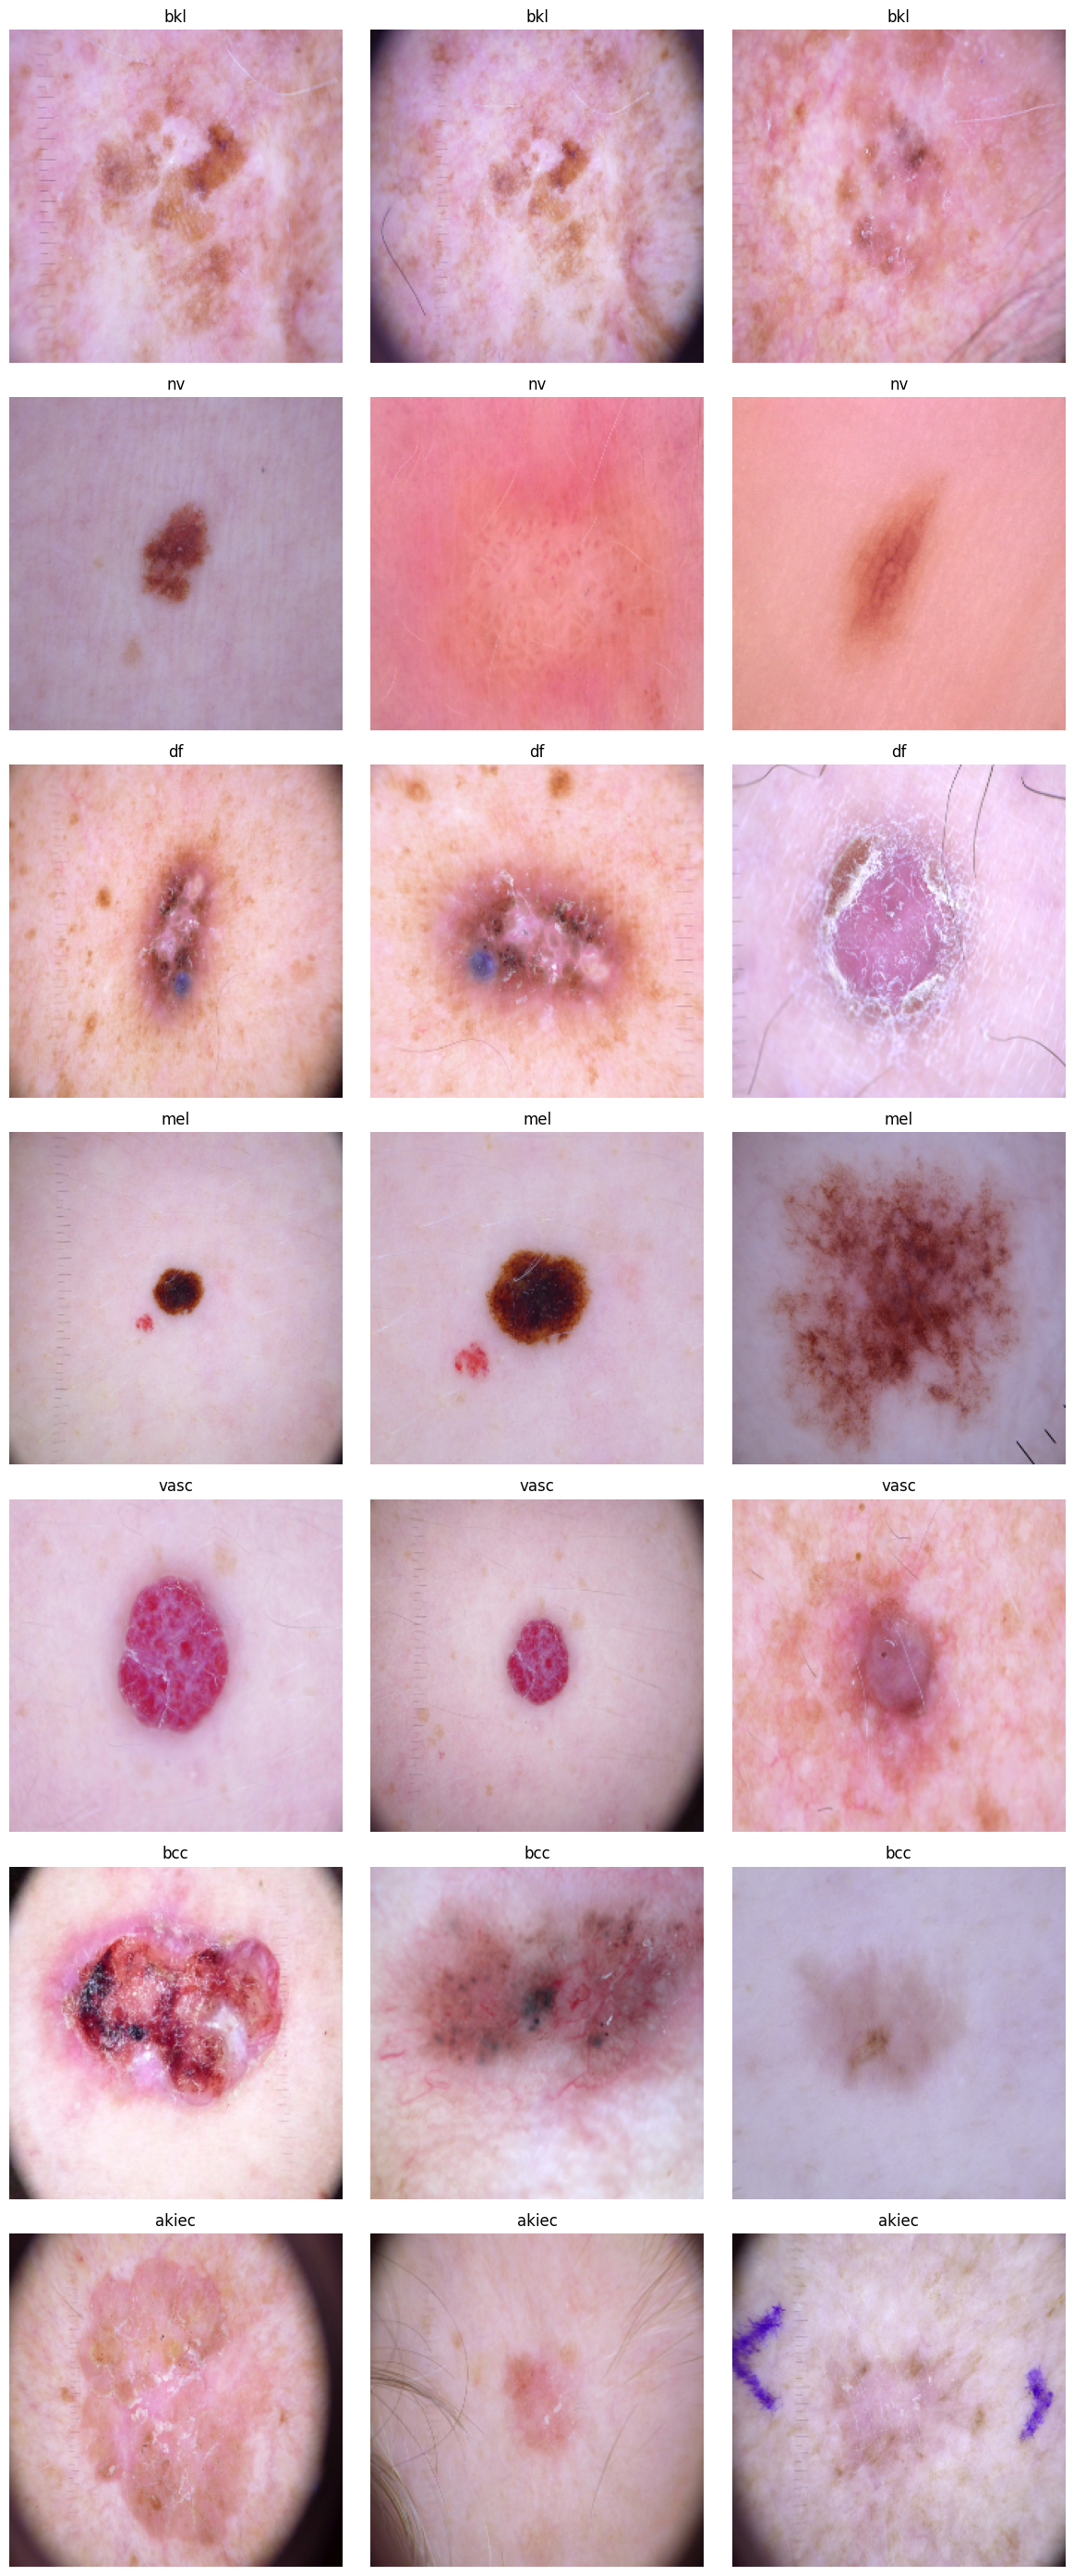

In [4]:
labels_unique = metadata["dx"].unique()

plt.figure(figsize=(12, 4 * len(labels_unique)))

for idx, label in enumerate(labels_unique):
    sample_rows = metadata[metadata["dx"] == label].head(3)
    
    for i, img_path in enumerate(sample_rows["image_path"].tolist()):
        img = cv2.imread(img_path)                      
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     
        img = cv2.resize(img, (224, 224))               
        
        plt.subplot(len(labels_unique), 3, idx * 3 + i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")

plt.tight_layout()
plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import *
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
metadata["label_encoded"]=encoder.fit_transform(metadata["dx"])
print(metadata["label_encoded"])

2025-08-13 13:00:11.324580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755090011.517317      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755090011.573593      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


0        2
1        2
2        2
3        2
4        2
        ..
10010    0
10011    0
10012    0
10013    0
10014    4
Name: label_encoded, Length: 10015, dtype: int64


In [5]:
df_label1 = metadata[metadata['label_encoded'] == 1]
#print(df_label1.value_counts())
df_label2 = metadata[metadata['label_encoded'] == 2]
#print(df_label2.value_counts())
df_label3 = metadata[metadata['label_encoded'] == 3]
#print(df_label3.value_counts())

df_label4 = metadata[metadata['label_encoded'] == 4]
#print(df_label4.value_counts())
df_label5 = metadata[metadata['label_encoded'] == 5]

df_label6 = metadata[metadata['label_encoded'] == 6]
#print(df_label6.value_counts())

df_label7 = metadata[metadata['label_encoded'] == 0]
#print(df_label7.value_counts())



df_label1_ovs = pd.concat([df_label1] * 12, ignore_index=True)
df_label2_ovs = pd.concat([df_label2] * 6, ignore_index=True)
df_label3_ovs = pd.concat([df_label3] * 57, ignore_index=True)#57
df_label4_ovs = pd.concat([df_label4] * 5, ignore_index=True)
df_label7_ovs = pd.concat([df_label7] * 20, ignore_index=True)
df_label6_ovs = pd.concat([df_label6] * 46, ignore_index=True)#46

final_metadata = pd.concat([
                        df_label1_ovs,
                        df_label2_ovs,
                        df_label3_ovs,
                        df_label4_ovs,
                        df_label5,
                        df_label7_ovs,
                        df_label6_ovs], ignore_index=True)



In [6]:
train_df, temp_df = train_test_split(final_metadata, test_size=0.3, random_state=42, stratify=final_metadata["label_encoded"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label_encoded"])

print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

Train set: 31261 images
Validation set: 6699 images
Test set: 6699 images


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 31261 validated image filenames belonging to 7 classes.
Found 6699 validated image filenames belonging to 7 classes.
Found 6699 validated image filenames belonging to 7 classes.


In [11]:
from tensorflow.keras.callbacks import *

early_stopping = EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=3)
model_checkpoint = ModelCheckpoint('Best_skin_cancer_model.h5', monitor='val_loss', save_best_only=True)


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *


In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

I0000 00:00:1755090113.558236      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,316,359 (69.87 MB)

 Trainable params: 16,058,375 (61.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.optimizers import *

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,validation_data=val_generator,epochs=40,batch_size=32,callbacks=[early_stopping,model_checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1755067221.193661     112 service.cc:148] XLA service 0x7d8cb533fe90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755067221.194392     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755067221.194413     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755067222.085624     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/977 ━━━━━━━━━━━━━━━━━━━━ 3:32:25 13s/step - accuracy: 0.1562 - loss: 3.2365

I0000 00:00:1755067226.786482     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


977/977 ━━━━━━━━━━━━━━━━━━━━ 636s 638ms/step - accuracy: 0.4744 - loss: 1.4844 - val_accuracy: 0.7312 - val_loss: 0.7330
Epoch 2/40
977/977 ━━━━━━━━━━━━━━━━━━━━ 511s 523ms/step - accuracy: 0.6589 - loss: 0.9054 - val_accuracy: 0.7907 - val_loss: 0.6030
Epoch 3/40
977/977 ━━━━━━━━━━━━━━━━━━━━ 511s 523ms/step - accuracy: 0.7034 - loss: 0.7799 - val_accuracy: 0.8024 - val_loss: 0.5236
Epoch 4/40
977/977 ━━━━━━━━━━━━━━━━━━━━ 513s 525ms/step - accuracy: 0.7333 - loss: 0.6918 - val_accuracy: 0.8206 - val_loss: 0.4751
Epoch 5/40
977/977 ━━━━━━━━━━━━━━━━━━━━ 510s 522ms/step - accuracy: 0.7593 - loss: 0.6219 - val_accuracy: 0.8415 - val_loss: 0.4475
Epoch 6/40
977/977 ━━━━━━━━━━━━━━━━━━━━ 511s 523ms/step - accuracy: 0.7731 - loss: 0.6018 - val_accuracy: 0.8406 - val_loss: 0.4133
Epoch 7/40
977/977 ━━━━━━━━━━━━━━━━━━━━ 507s 519ms/step - accuracy: 0.7835 - loss: 0.5701 - val_accuracy: 0.8482 - val_loss: 0.3933
Epoch 8/40
977/977 ━━━━━━━━━━━━━━━━━━━━ 508s 520ms/step - accuracy: 0.7901 - loss: 0.53

In [10]:

from tensorflow.keras.models import load_model
model = load_model('/kaggle/input/best-skin-cancer-model1/best_skin_cancer_model.h5')

In [17]:
from tensorflow.keras.optimizers import *

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

history = model.fit(train_generator,validation_data=val_generator,epochs=40,batch_size=32,initial_epoch=18,callbacks=[early_stopping,model_checkpoint])

Epoch 19/40
977/977 ━━━━━━━━━━━━━━━━━━━━ 663s 677ms/step - accuracy: 0.8586 - loss: 0.3767 - val_accuracy: 0.9042 - val_loss: 0.2712
Epoch 20/40
580/977 ━━━━━━━━━━━━━━━━━━━━ 3:35 543ms/step - accuracy: 0.8581 - loss: 0.3737

In [19]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


210/210 ━━━━━━━━━━━━━━━━━━━━ 57s 272ms/step - accuracy: 0.8920 - loss: 0.2739
Test Accuracy: 0.8916256427764893
Test Loss: 0.27861538529396057


In [21]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,validation_data=val_generator,epochs=15,batch_size=32,callbacks=[early_stopping,model_checkpoint])


Epoch 1/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 577s 591ms/step - accuracy: 0.8893 - loss: 0.2847 - val_accuracy: 0.9189 - val_loss: 0.2364
Epoch 2/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 554s 567ms/step - accuracy: 0.8884 - loss: 0.2813 - val_accuracy: 0.9177 - val_loss: 0.2340
Epoch 3/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 553s 566ms/step - accuracy: 0.8893 - loss: 0.2833 - val_accuracy: 0.9127 - val_loss: 0.2423
Epoch 4/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 561s 574ms/step - accuracy: 0.8891 - loss: 0.2829 - val_accuracy: 0.9213 - val_loss: 0.2283
Epoch 5/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 554s 567ms/step - accuracy: 0.8932 - loss: 0.2786 - val_accuracy: 0.9179 - val_loss: 0.2377
Epoch 6/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 554s 566ms/step - accuracy: 0.8967 - loss: 0.2695 - val_accuracy: 0.9170 - val_loss: 0.2276
Epoch 7/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 557s 570ms/step - accuracy: 0.8955 - loss: 0.2725 - val_accuracy: 0.9201 - val_loss: 0.2287
Epoch 8/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 561s 574ms/step - accuracy: 0.8950 -

In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


210/210 ━━━━━━━━━━━━━━━━━━━━ 49s 233ms/step - accuracy: 0.9219 - loss: 0.2084
Test Accuracy: 0.9225257635116577
Test Loss: 0.21183329820632935


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


210/210 ━━━━━━━━━━━━━━━━━━━━ 48s 228ms/step


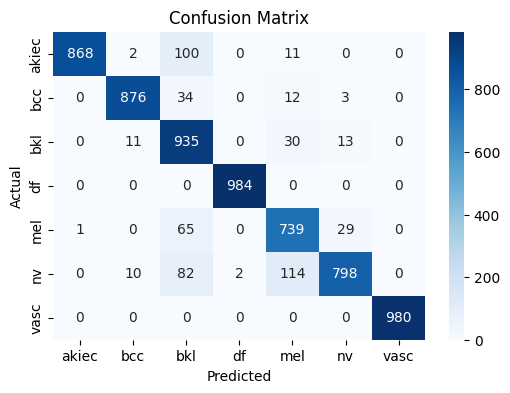

Classification Report:

              precision    recall  f1-score   support

       akiec       1.00      0.88      0.94       981
         bcc       0.97      0.95      0.96       925
         bkl       0.77      0.95      0.85       989
          df       1.00      1.00      1.00       984
         mel       0.82      0.89      0.85       834
          nv       0.95      0.79      0.86      1006
        vasc       1.00      1.00      1.00       980

    accuracy                           0.92      6699
   macro avg       0.93      0.92      0.92      6699
weighted avg       0.93      0.92      0.92      6699



In [23]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

In [24]:
model.save("skin_cancer_MobileNetV2_finetuned.h5")
